In [8]:
import warnings
warnings.filterwarnings("ignore")
import hcp_utils as hcp
import pandas as pd
import numpy as np
import nibabel as nib
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import scipy.stats as ss
import func_plot as fp
import func_stats as fs
from brainspace.datasets import load_conte69
lh, rh = load_conte69()

# Profiles

## Glasser

In [2]:
sub = pd.read_csv('../mics/MICs_rename-equivalence_old_dataset.csv')
path = '../mics/data/'
data_density = [None]*50 # peopleID, surface, parcel
for i in range(50):
    data_density[i] = nib.load(path+'sub-'+sub['Original'][i]+
                              '_ses-01_atlas-glasser-360_desc-intensity_profiles.shape.gii').agg_data()

In [3]:
data_density = np.array(data_density).mean(axis=1)
data_density.shape

(50, 362)

In [4]:
lh_inten = np.zeros((50,180))
rh_inten = np.zeros((50,180))
for i in range(50):
  lh_inten[i] = -np.array(data_density)[i,1:181]
  rh_inten[i] = -np.array(data_density)[i,182:]

lh_z = np.array([ss.zscore(lh_inten[n]) for n in range(50)])
rh_z = np.array([ss.zscore(rh_inten[n]) for n in range(50)])

In [5]:
lh_z.shape

(50, 180)

In [6]:
mp = np.concatenate((lh_z, rh_z),axis=1)
mp.shape

(50, 360)

In [9]:
ca = np.array(pd.read_csv('../data/ca_glasser_network.csv', header = None))[:,0]
cmap = ListedColormap(np.vstack((list(hcp.ca_network['rgba'].values())))[1:])
color = ca[:180]

In [10]:
ca_lh = np.zeros((50,12)) # sub, ca
ca_rh = np.zeros((50,12))
for i in range(50):
  for n in range(12):
    ca_lh[i,n] = np.mean(lh_z[i][ca[:180]==n+1])
    ca_rh[i,n] = np.mean(rh_z[i][ca[180:]==n+1])

In [11]:
asy_total = lh_z - rh_z
a = []
for i in range(180):
  a.append(ss.ttest_1samp(asy_total[:,i],0))
cohen = np.array(a)[:,0]/pow(1101, 0.5)
df_total = pd.DataFrame(np.vstack((np.array(a).T, fs.fdr(np.array(a)[:,1]), cohen)).T)
df_total.columns = ['t', 'p', 'p_fdr','cohen']
df_total.to_csv('../mics/stat_mics_intensity_asy_total_parcel.csv', index=None)
df_total

,t,p,p_fdr,cohen
0,-2.040902,4.666647e-02,7.241349e-02,-0.061508
1,2.183757,3.379711e-02,5.431678e-02,0.065813
2,-2.032279,4.756421e-02,7.317571e-02,-0.061248
3,-2.090549,4.177822e-02,6.539199e-02,-0.063004
4,-4.702799,2.126158e-05,5.628067e-05,-0.141730
...,...,...,...,...
175,11.907433,4.493111e-16,6.739666e-15,0.358860
176,6.465268,4.470276e-08,2.298999e-07,0.194847
177,6.755666,1.586184e-08,9.517106e-08,0.203598
178,7.674282,6.033538e-10,4.344147e-09,0.231283


In [12]:
ca_asy = ca_lh - ca_rh
a = []
for i in range(12):
  a.append(ss.ttest_1samp(ca_asy[:,i],0))
cohen_ca = np.array(a)[:,0]/pow(1101, 0.5)
df = pd.DataFrame(np.vstack((fp.network_name, np.array(a).T, fs.fdr(np.array(a)[:,1]), cohen_ca)).T)
df.columns = ['CA_label', 't', 'p', 'p_fdr','cohen_d']
df = df.sort_values(by=['t'])
df.style.set_caption("asymetry VS 0 network-wise")

,CA_label,t,p,p_fdr,cohen_d
4,DAN,-15.793127838108017,7.384708266566913e-21,4.4308249599401475e-20,-0.4759644226383513
10,VMN,-16.33092389897226,1.850584175600768e-21,2.2207010107209213e-20,-0.49217221847400466
2,SMN,-4.6148696951683705,2.857341441794265e-05,3.80978858905902e-05,-0.13908035270327904
1,Vis2,-7.937466268589192,2.381250985311083e-10,4.762501970622166e-10,-0.23921490337236667
0,Vis1,-8.299301996020779,6.684947075303175e-11,1.6043872980727622e-10,-0.2501197054395887
9,PMN,0.044485283603680606,0.964698378972425,0.9646983789724249,0.0013406725091681196
8,DMN,0.6956012135146915,0.4899646657352036,0.5345069080747676,0.020963638955557237
7,AUD,12.961099742600515,1.8826921097419848e-17,7.530768438967939e-17,0.39061434941718126
5,LAN,4.5412146050393005,3.6550493921430313e-05,4.386059270571638e-05,0.13686057693707093
3,CON,6.721593821975496,1.791275254280912e-08,2.6869128814213678e-08,0.20257162200425385


In [13]:
glasser = np.genfromtxt('../data/glasser.csv')
glasser_l = glasser[:32492]
glasser_r = glasser[32492:]
glasser_r[glasser_r==180]=0
glasser = np.concatenate((glasser_l,glasser_r))
mask = glasser != 0

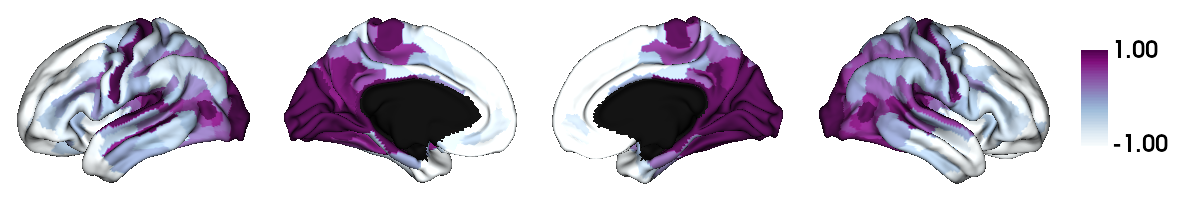

In [25]:
mask = glasser != 0
plot = map_to_labels(mp.mean(axis=0), glasser, mask=mask)
np.savetxt('../mics/MICs_intensity_z_mean.txt',mp.mean(axis=0))
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'BuPu', filename = '../figures/mics/mean.png')

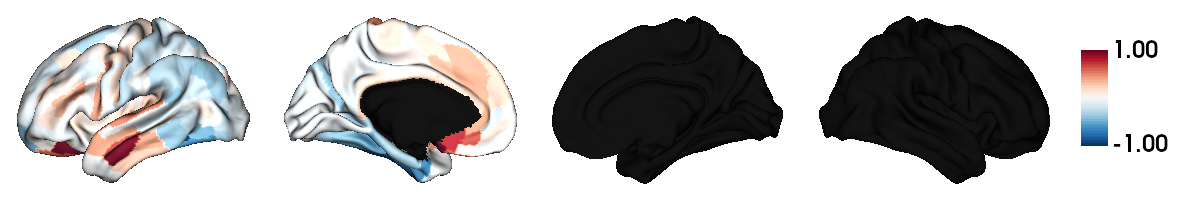

In [26]:
ai_mean = mp.mean(axis=0)[:180] - mp.mean(axis=0)[180:]
plot = map_to_labels(np.concatenate((ai_mean,np.zeros(180))), glasser, mask=mask)
np.savetxt('../mics/MICs_intensity_asy_mean.txt',ai_mean)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'RdBu_r', filename = '../figures/mics/mics_ai_mean.png')

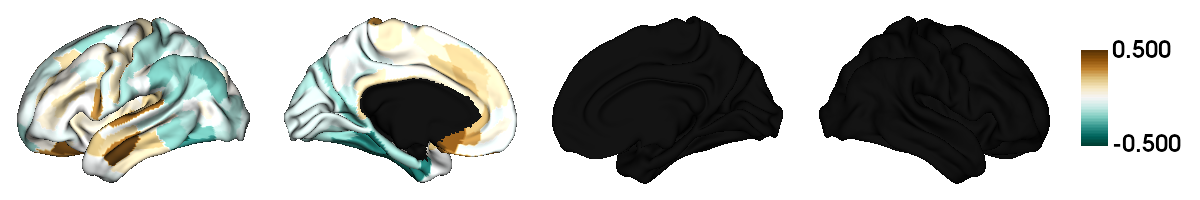

In [16]:
data = cohen.copy()
plot = map_to_labels(np.concatenate((data,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-0.5,0.5),
                   cmap = 'BrBG_r', filename = '../figures/mics/cohen_asy_overall.png')

[PearsonRResult(statistic=0.23365128189566453, pvalue=0.0015954739498400265),
 '=0.146']

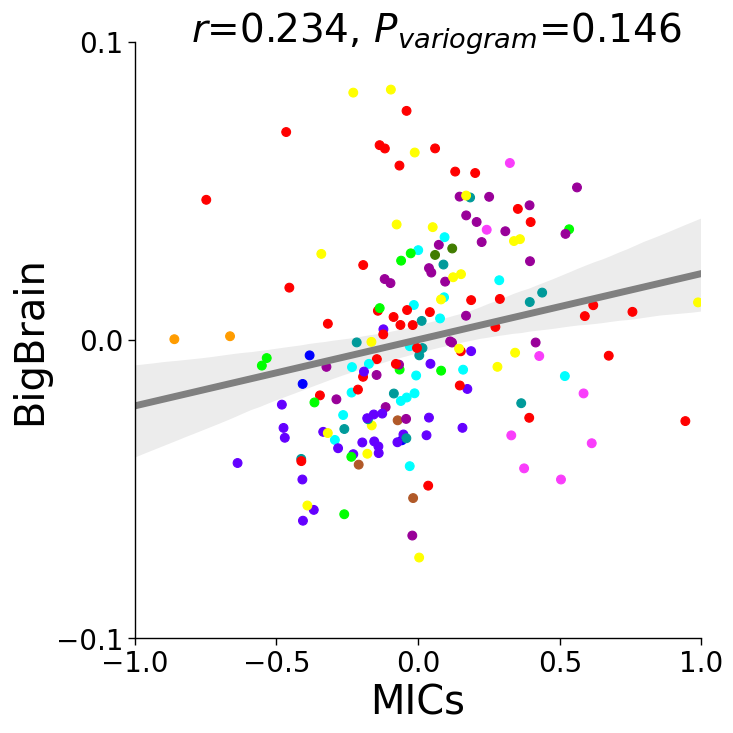

In [19]:
data = asy_total.mean(axis=0).copy()
bb_asy = np.loadtxt('../bigbrain/bigbrain_asy_mean.txt')
target = bb_asy.copy()
rp = fs.spin_pearson(data, target)
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target, ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.1, 0.1)
ax.set_yticks([-0.1, 0, 0.1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xlabel('MICs')
ax.set_ylabel('BigBrain')
if rp[1] == 0:
   rp[1] = '<0.001'
else:
   rp[1] = '=%.3f'%(rp[1])
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$'+rp[1], 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/mics/corr_mics_bb_asy_mean.png', dpi=300, transparent=True)
rp

[PearsonRResult(statistic=0.5477602634549692, pvalue=1.7519239590932296e-15),
 '=0.004']

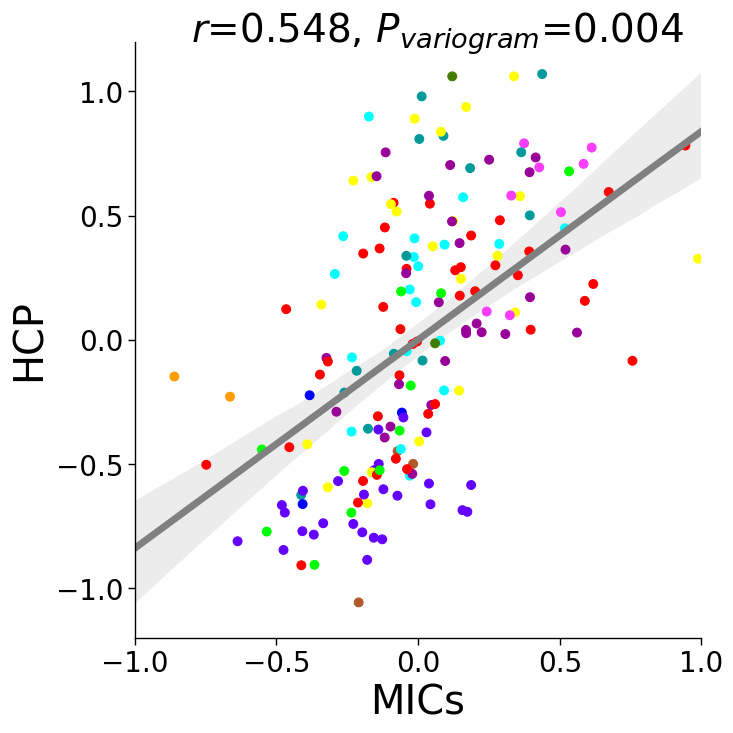

In [18]:
data = asy_total.mean(axis=0)
hcp_asy = np.loadtxt('../hcp/intensity_asy_mean.txt')
target = hcp_asy.copy()
rp = fs.spin_pearson(data, target)
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target, ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([-1.2, 1.2])
ax.set_xlim([-1, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xlabel('MICs')
ax.set_ylabel('HCP')
if rp[1] == 0:
   rp[1] = '<0.001'
else:
   rp[1] = '=%.3f'%(rp[1])
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$'+rp[1], 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/mics/corr_mics_hcp_asy_mean.png', dpi=300, transparent=True)
rp

## Sex Age effects

In [20]:
demo = pd.read_csv('../mics/participants.tsv', sep='\t')
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
demo.age[demo.age=='15-20'] = 1
demo.age[demo.age=='20-25'] = 2
demo.age[demo.age=='25-30'] = 3
demo.age[demo.age=='30-35'] = 4
demo.age[demo.age=='35-40'] = 5
demo.age[demo.age=='40-45'] = 6
demo.sex[demo.sex=='F'] = 0
demo.sex[demo.sex=='M'] = 1

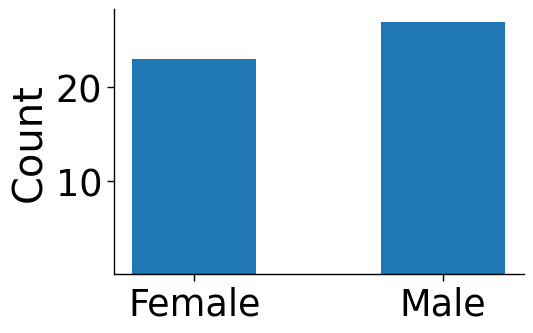

In [21]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(demo.sex,bins=[0,0.5,1,1.5])
ax.set_xticks([0.25,1.25])
ax.set_yticks([10,20])
ax.set_ylabel('Count')
ax.set_xticklabels(['Female','Male'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../figures/mics/sex_distribution.png', dpi=300, transparent=True)

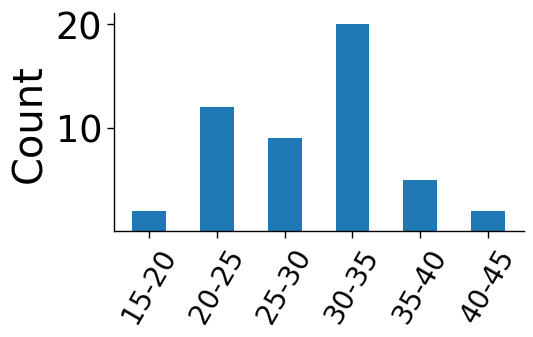

In [22]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(demo.age, bins=[1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5])
ax.set_xticks([1.25,2.25,3.25,4.25,5.25,6.25])
ax.set_yticks([10,20])
ax.set_ylabel('Count')
ax.set_xticklabels(['15-20','20-25','25-30','30-35','35-40','40-45'], rotation=60,fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../figures/mics/age_distribution.png', dpi=300, transparent=True)

In [23]:
demo.sex[demo.sex==0] = 'F'
demo.sex[demo.sex==1] = 'M'
sex = FixedEffect(demo.sex, 'sex')
age = FixedEffect(np.array(demo.age).astype(float), 'age')
sum(sex.sex_F)/50, age.age.mean()

(0.46, 3.4)

In [24]:
model = sex + age + sex*age
slm_age_sex = SLM(model, contrast=model.matrix['sex_M*age'])
slm_age_sex.fit(asy_total)
t_age_sex = slm_age_sex.t[0]
p_age_sex = np.zeros(180)
dof = model.shape[0] - model.shape[1]
for i in range(180):
  p_age_sex[i] = ss.t.sf(abs(t_age_sex[i]), dof) * 2
if len(np.where(fs.fdr(p_age_sex)<0.05)[0]) == 0:
  print('no age*sex interaction')
  model = sex + age
  slm_sex = SLM(model, contrast=model.sex_M)
  slm_sex.fit(asy_total)
  slm_age = SLM(model, contrast=model.age)
  slm_age.fit(asy_total)
  t_sex = slm_sex.t[0]
  t_age = slm_age.t[0]
  p_sex = np.zeros(180)
  p_age = np.zeros(180)
  dof = model.shape[0] - model.shape[1]
  for i in range(180):
    p_sex[i] = ss.t.sf(abs(t_sex[i]), dof) * 2
    p_age[i] = ss.t.sf(abs(t_age[i]), dof) * 2
else:
  np.where(fs.fdr(p_age_sex)<0.05)[0]

np.savetxt('../mics/MICs_sex_t.txt', t_sex)
np.savetxt('../mics/MICs_sex_p.txt', p_sex)
np.savetxt('../mics/MICs_sex_pfdr.txt', fs.fdr(p_sex))
np.savetxt('../mics/MICs_age_t.txt', t_age)
np.savetxt('../mics/MICs_age_p.txt', p_age)
np.savetxt('../mics/MICs_age_pfdr.txt', fs.fdr(p_age))

no age*sex interaction


In [22]:
[t_sex.min(), t_sex.max(), t_age.min(), t_age.max(),
 p_sex.min(), p_sex.max(), p_age.min(), p_age.max(),] 

[-4.617536327234424,
 4.552283460493472,
 -2.9749052741772877,
 3.1695540176431427,
 3.1331007492459034e-05,
 0.9847929648044413,
 0.002714752492511501,
 0.9948298042843675]

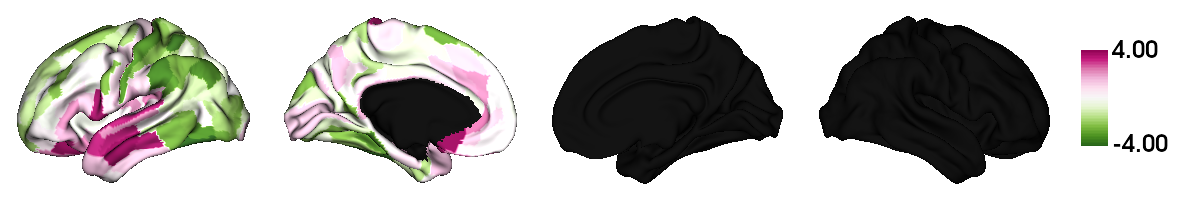

In [23]:
plot = t_sex.copy()
#plot[fs.fdr(p_sex)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-4,4),
                   cmap = 'PiYG_r', filename = '../figures/mics/asy_tmap_sex.png')

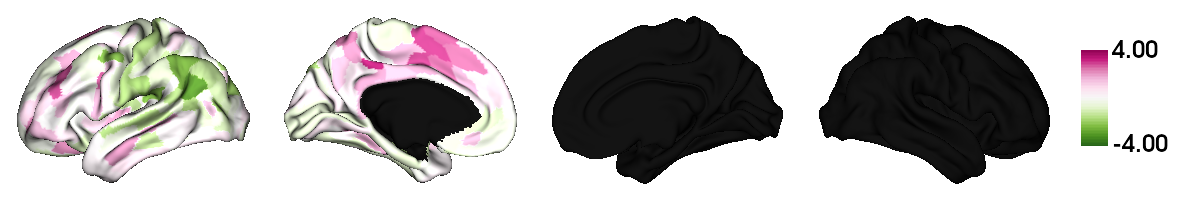

In [24]:
plot = t_age.copy()
#plot[fs.fdr(p_age)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-4,4),
                   cmap = 'PiYG_r', filename = '../figures/mics/asy_tmap_age.png')

([(0.7313473724696034, 2.1092341320574502e-31), '<0.001'],
 [(0.2240721112610994, 0.0024958515518964724), '=0.062'])

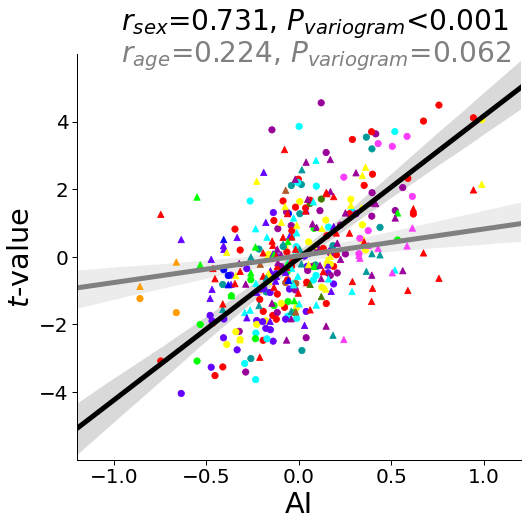

In [25]:
target1=t_sex.copy()
target2=t_age.copy()
data = ai_mean.copy()
rp1 = fs.spin_pearson(data, target1)
rp2 = fs.spin_pearson(data, target2)
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target1, ax = ax, 
            scatter_kws={'s': 0, 'color': 'red'},
            line_kws={'lw': 5, 'color': 'black'})
sns.regplot(data, target2, ax = ax, 
            scatter_kws={'s': 0, 'color': 'blue'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target1, c=ca[:180], cmap=cmap, s=40)
ax.scatter(data, target2, c=ca[:180], cmap=cmap, s=40, marker='^')
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-6, 6)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-4, -2, 0, 2, 4])
ax.set_xlabel('AI')
ax.set_ylabel('$\it{t}$-value')
if rp1[1] == 0:
   rp1[1] = '<0.001'
else:
   rp1[1] = '=%.3f'%(rp1[1])
if rp2[1] == 0:
   rp2[1] = '<0.001'
else:
   rp2[1] = '=%.3f'%(rp2[1])
   
ax.text(0.1, 1.06, '$\it{r}$$_{sex}$=' + '%.3f'%(rp1[0][0])+', $\it{P}$$_{variogram}$'+rp1[1], 
        fontsize=28, c='black', transform=ax.transAxes)
ax.text(0.1, 0.98, '$\it{r}$$_{age}$=' + '%.3f'%(rp2[0][0])+', $\it{P}$$_{variogram}$'+rp2[1], 
        fontsize=28, c='grey', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/mics/corr_tmap_sex_age.png', dpi=300, transparent=True)
rp1, rp2

In [26]:
ca_asy.shape,asy_total.shape

((50, 12), (50, 180))

In [27]:
model = sex + age + sex*age
slm_age_sex = SLM(model, contrast=model.matrix['sex_M*age'])
slm_age_sex.fit(ca_asy)
t_age_sex = slm_age_sex.t[0]
p_age_sex = np.zeros(12)
dof = model.shape[0] - model.shape[1]
for i in range(12):
  p_age_sex[i] = ss.t.sf(abs(t_age_sex[i]), dof) * 2
if len(np.where(fs.fdr(p_age_sex)<0.05)[0]) == 0:
  print('no age*sex interaction')
  model = sex + age
  slm_sex = SLM(model, contrast=model.sex_M)
  slm_sex.fit(ca_asy)
  slm_age = SLM(model, contrast=model.age)
  slm_age.fit(ca_asy)
  t_sex = slm_sex.t[0]
  t_age = slm_age.t[0]
  p_sex = np.zeros(12)
  p_age = np.zeros(12)
  dof = model.shape[0] - model.shape[1]
  for i in range(12):
    p_sex[i] = ss.t.sf(abs(t_sex[i]), dof) * 2
    p_age[i] = ss.t.sf(abs(t_age[i]), dof) * 2
else:
  np.where(fs.fdr(p_age_sex)<0.05)[0]

no age*sex interaction
